<a href="https://colab.research.google.com/github/zdiana/pp2-20B030130/blob/main/NLP_midka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1. Data Preprocessing and Word Embeddings


In [ ]:
import pandas as pd
import spacy
data = pd.read_csv('IMDB Dataset.csv')

subset_data = data.sample(n=5000, random_state=42).reset_index(drop=True)

nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)
subset_data['clean_review'] = subset_data['review'].apply(preprocess_text)
subset_data.head()


,review,sentiment,clean_review
0,I really liked this Summerslam due to the look...,positive,like summerslam look arena curtain look overal...
1,Not many television shows appeal to quite as m...,positive,television show appeal different kind fan like...
2,The film quickly gets to a major chase scene w...,negative,film quickly get major chase scene increase de...
3,Jane Austen would definitely approve of this o...,positive,jane austen definitely approve paltrow awesome...
4,Expectations were somewhat high for me when I ...,negative,expectation somewhat high go movie think steve...


In [ ]:
print(subset_data['sentiment'].unique())


['positive' 'negative']


In [ ]:

import pandas as pd
import spacy
import gensim
from gensim.models import Word2Vec, FastText, KeyedVectors
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from gensim.scripts.glove2word2vec import glove2word2vec

tokenized_reviews = [review.split() for review in subset_data['clean_review']]

print("Example:", tokenized_reviews[0])


Example: ['like', 'summerslam', 'look', 'arena', 'curtain', 'look', 'overall', 'interesting', 'reason', 'anyway', 'good', 'summerslam', 'wwf', 'lex', 'luger', 'main', 'event', 'yokozuna', 'time', 'ok', 'huge', 'fat', 'man', 'vs', 'strong', 'man', 'glad', 'time', 'change', 'terrible', 'main', 'event', 'like', 'match', 'luger', 'terrible', 'match', 'card', 'razor', 'ramon', 'vs', 'ted', 'dibiase', 'steiner', 'brothers', 'vs', 'heavenly', 'bodies', 'shawn', 'michaels', 'vs', 'curt', 'hening', 'event', 'shawn', 'name', 'big', 'monster', 'body', 'guard', 'diesel', 'irs', 'vs', 'kid', 'bret', 'hart', 'take', 'doink', 'take', 'jerry', 'lawler', 'stuff', 'harts', 'lawler', 'interesting', 'ludvig', 'borga', 'destroy', 'marty', 'jannetty', 'undertaker', 'take', 'giant', 'gonzalez', 'terrible', 'match', 'smoking', 'gunns', 'tatanka', 'take', 'bam', 'bam', 'bigelow', 'headshrinkers', 'yokozuna', 'defend', 'world', 'title', 'lex', 'luger', 'match', 'boring', 'terrible', 'ending', 'deserve']


In [ ]:
# model Word2Vec
w2v_cbow = Word2Vec(
    sentences=tokenized_reviews,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=0,
    seed=42
)

# Word2Vec with Skip-gram (sg=1)
w2v_skipgram = Word2Vec(
    sentences=tokenized_reviews,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,               # Skip-gram
    seed=42
)

#FastText
ft_model = FastText(
    sentences=tokenized_reviews,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=42
)


In [ ]:
from gensim.models import KeyedVectors

glove_input_file = 'glove.6B.100d.txt'
glove_model = KeyedVectors.load_word2vec_format(glove_input_file, binary=False, no_header=True)


In [ ]:
words_to_compare = ['good', 'bad']

print("Word2Vec CBOW similarity ('good' vs 'bad'):",
      w2v_cbow.wv.similarity('good', 'bad'))
print("Word2Vec Skip-gram similarity ('good' vs 'bad'):",
      w2v_skipgram.wv.similarity('good', 'bad'))
print("FastText similarity ('good' vs 'bad'):",
      ft_model.wv.similarity('good', 'bad'))
print("GloVe similarity ('good' vs 'bad'):",
      glove_model.similarity('good', 'bad'))


Word2Vec CBOW similarity ('good' vs 'bad'): 0.8856322
Word2Vec Skip-gram similarity ('good' vs 'bad'): 0.6904798
FastText similarity ('good' vs 'bad'): 0.95517296
GloVe similarity ('good' vs 'bad'): 0.7702798


Number of common words for visualization: 100


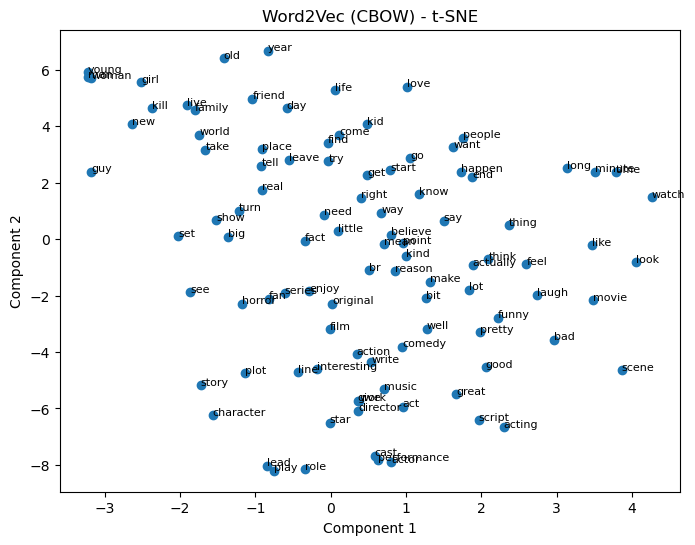

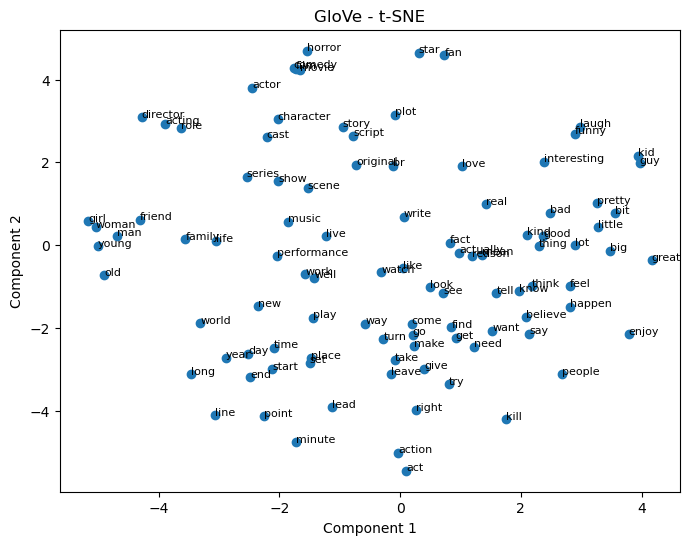

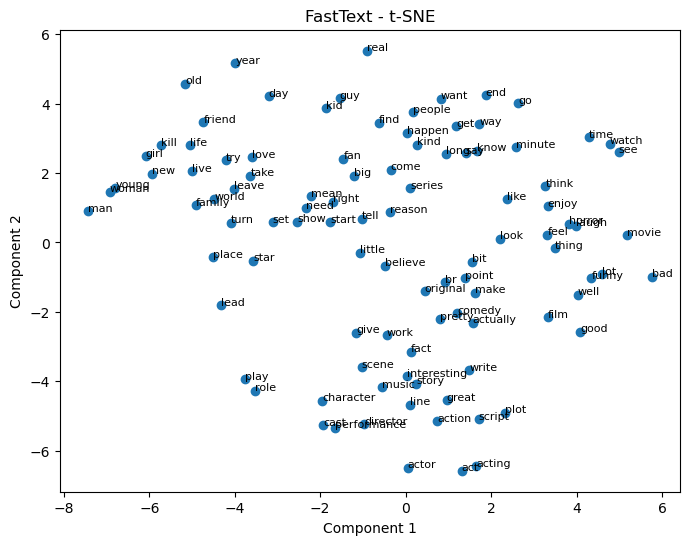

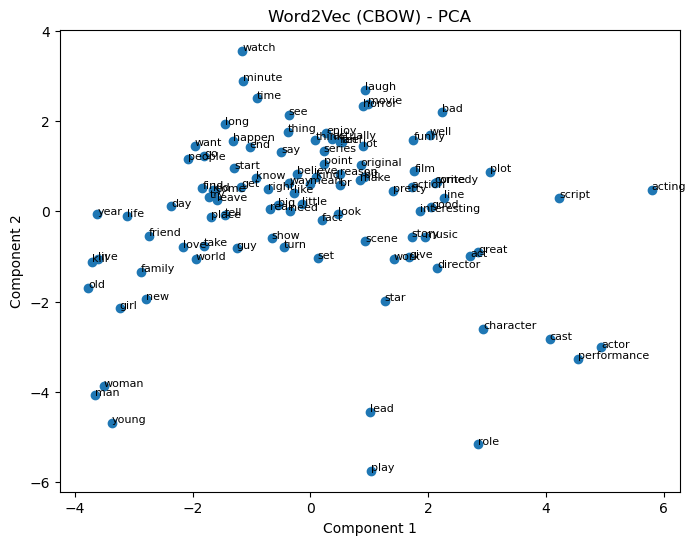

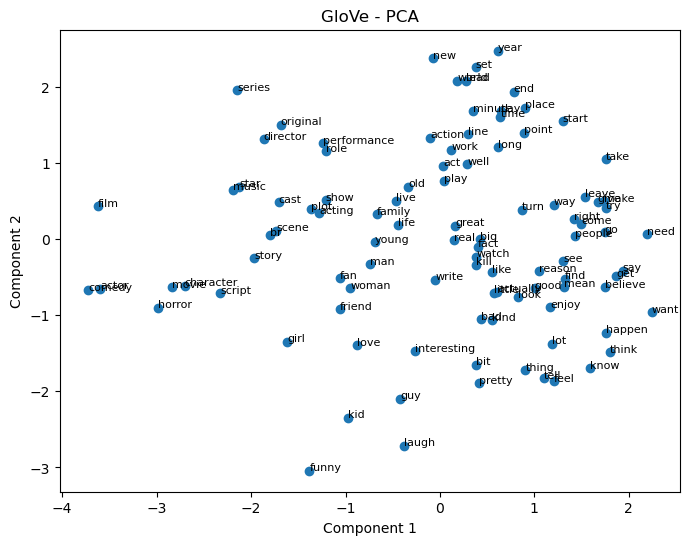

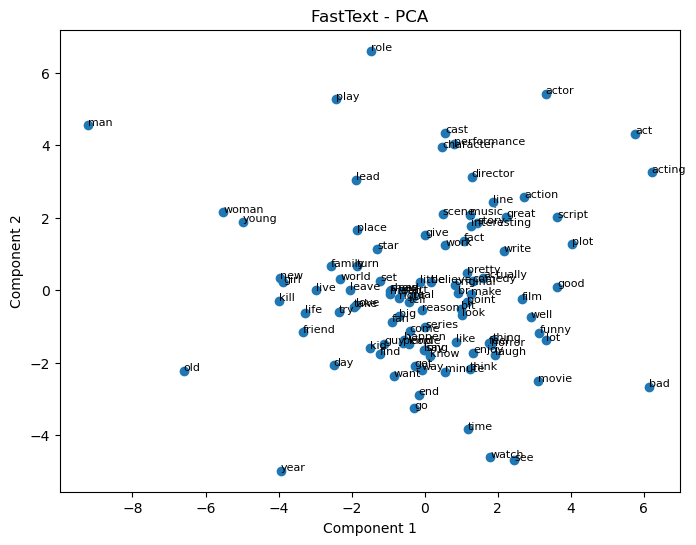

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

common_words = list(set(w2v_cbow.wv.index_to_key) &
                    set(glove_model.index_to_key) &
                    set(ft_model.wv.index_to_key))

# Sorting common words by frequency by using counts from Word2Vec CBOW
common_words = sorted(common_words, key=lambda word: w2v_cbow.wv.get_vecattr(word, "count"), reverse=True)

# Limit the number
num_words = min(100, len(common_words))
common_words = common_words[:num_words]

print(f"Number of common words for visualization: {len(common_words)}")

# Extracting embeddings for each word from each model
embeddings_w2v = np.array([w2v_cbow.wv[word] for word in common_words])
embeddings_glove = np.array([glove_model[word] for word in common_words])
embeddings_ft = np.array([ft_model.wv[word] for word in common_words])

#plot embeddings
def plot_embeddings(embeddings, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1])
    for i, word in enumerate(common_words):
        plt.annotate(word, (embeddings[i, 0], embeddings[i, 1]), fontsize=8)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

#Visualization using t-SNE
tsne_w2v = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
embeddings_w2v_tsne = tsne_w2v.fit_transform(embeddings_w2v)

tsne_glove = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
embeddings_glove_tsne = tsne_glove.fit_transform(embeddings_glove)

tsne_ft = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
embeddings_ft_tsne = tsne_ft.fit_transform(embeddings_ft)

plot_embeddings(embeddings_w2v_tsne, "Word2Vec (CBOW) - t-SNE")
plot_embeddings(embeddings_glove_tsne, "GloVe - t-SNE")
plot_embeddings(embeddings_ft_tsne, "FastText - t-SNE")

#Visualization using PCA
pca = PCA(n_components=2)

embeddings_w2v_pca = pca.fit_transform(embeddings_w2v)
embeddings_glove_pca = pca.fit_transform(embeddings_glove)
embeddings_ft_pca = pca.fit_transform(embeddings_ft)

plot_embeddings(embeddings_w2v_pca, "Word2Vec (CBOW) - PCA")
plot_embeddings(embeddings_glove_pca, "GloVe - PCA")
plot_embeddings(embeddings_ft_pca, "FastText - PCA")


Task 2. Building Recurrent Neural Networks for Sentiment Analysis

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
print("Unique sentiment values (before mapping):", subset_data['sentiment'].unique())

Unique sentiment values (before mapping): [1 0]


In [ ]:
subset_data['sentiment'] = subset_data['sentiment'].str.strip().str.lower()
subset_data['sentiment'] = subset_data['sentiment'].map({'positive': 1, 'negative': 0})

print("Unique sentiment values (after mapping):", subset_data['sentiment'].unique())
print("Value counts:\n", subset_data['sentiment'].value_counts(dropna=False))

Unique sentiment values (after mapping): [1 0]
Value counts:
 sentiment
1    2519
0    2481
Name: count, dtype: int64


In [ ]:
train_df, val_df = train_test_split(subset_data, test_size=0.2, random_state=42)

In [ ]:
#Tokenize and pad sequences
max_vocab = 10000  # max number of words to keep
max_length = 100   # max sequence length (tokens)

tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_review'].tolist())

train_sequences = tokenizer.texts_to_sequences(train_df['clean_review'].tolist())
val_sequences = tokenizer.texts_to_sequences(val_df['clean_review'].tolist())

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')

train_labels = train_df['sentiment'].values
val_labels = val_df['sentiment'].values

In [ ]:
import tensorflow as tf
import numpy as np

class SimpleRNNVanishingGradModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Define our own loss function and metrics
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.acc_metric = tf.keras.metrics.BinaryAccuracy()

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.loss_fn(y, y_pred)

        # Compute and apply gradients
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Compute average gradient norm
        valid_grads = [g for g in grads if g is not None]
        if valid_grads:
            avg_grad_norm = tf.add_n([tf.norm(g) for g in valid_grads]) / len(valid_grads)
        else:
            avg_grad_norm = 0.0

        # Update our own accuracy metric
        self.acc_metric.update_state(y, y_pred)

        # Build logs dict with pure floats
        logs = {}
        logs["loss"] = float(loss.numpy())
        logs["accuracy"] = float(self.acc_metric.result().numpy())
        logs["grad_norm"] = float(avg_grad_norm.numpy())
        return logs

    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        loss = self.loss_fn(y, y_pred)

        # Update metric
        self.acc_metric.update_state(y, y_pred)

        # Build logs dict
        logs = {}
        logs["loss"] = float(loss.numpy())
        logs["accuracy"] = float(self.acc_metric.result().numpy())
        return logs

    def reset_metrics(self):
        # Keras calls this at the start of each epoch
        self.acc_metric.reset_state()
        return super().reset_metrics()



In [ ]:
def build_simple_rnn_model(vocab_size, embedding_dim, rnn_units):
    inputs = tf.keras.layers.Input(shape=(None,), dtype=tf.int32)
    x = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    x = tf.keras.layers.SimpleRNN(rnn_units, activation='tanh')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Wrap in our custom subclass
    model = SimpleRNNVanishingGradModel(inputs=inputs, outputs=outputs)
    return model

# Example hyperparameters
max_vocab = 10000
embedding_dim = 64
rnn_units = 64

model = build_simple_rnn_model(max_vocab, embedding_dim, rnn_units)

# Compile with an optimizer only (no 'loss' or 'metrics' here, since we handle them in train_step/test_step)
model.compile(optimizer='adam')
model.summary()

Model: "simple_rnn_vanishing_grad_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,321 (2.47 MB)

 Trainable params: 648,321 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = build_simple_rnn_model(max_vocab, embedding_dim, rnn_units)
model.compile(
    optimizer='adam',
    run_eagerly=True
)
history = model.fit(
    x=train_padded,
    y=train_labels,
    validation_data=(val_padded, val_labels),
    epochs=5,
    batch_size=64
)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5078 - grad_norm: 0.2105 - loss: 0.6972 - val_loss: 0.6880 - val_accuracy: 0.5090
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6846 - grad_norm: 0.4800 - loss: 0.6132 - val_loss: 0.6868 - val_accuracy: 0.5070
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8362 - grad_norm: 0.9782 - loss: 0.4067 - val_loss: 0.6849 - val_accuracy: 0.5170
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9301 - grad_norm: 1.1422 - loss: 0.2107 - val_loss: 0.9310 - val_accuracy: 0.5290
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9886 - grad_norm: 0.5536 - loss: 0.0575 - val_loss: 0.8012 - val_accuracy: 0.5220


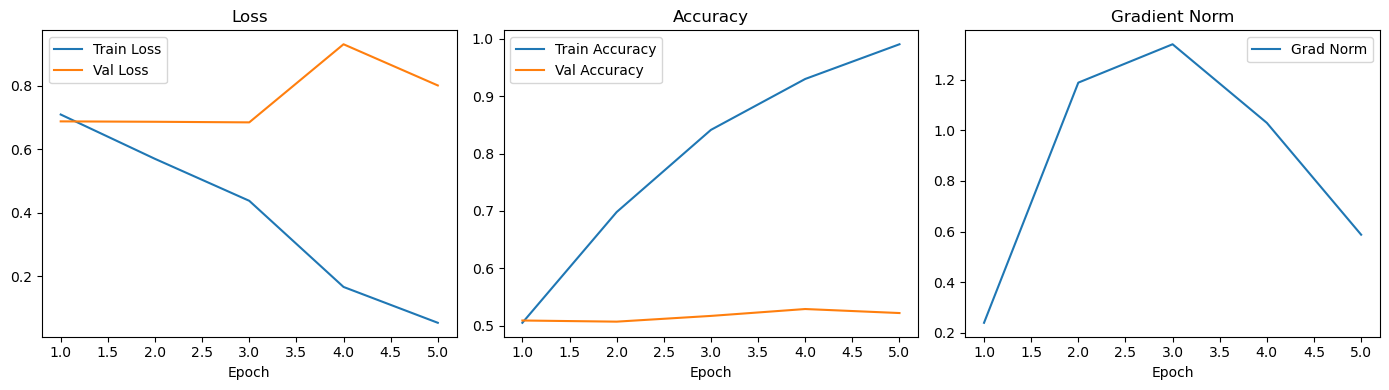

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, 6)

plt.figure(figsize=(14, 4))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot Gradient Norm (only for training)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history.history['grad_norm'], label='Grad Norm')
plt.title('Gradient Norm')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


Task 3. Implementing LSTM and GRU for Text Classification

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example hyperparameters
max_words = 10000
max_len = 100
embedding_dim = 100

texts = subset_data['clean_review'].tolist()
labels = subset_data['sentiment'].values

# Create a tokenizer and fit it on the texts
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Convert texts to sequences and pad them
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=max_words,
        output_dim=100,
        input_shape=(max_len,)  # Explicit input shape (excluding batch dimension)
    ),
    tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True, dropout=0.2),
    tf.keras.layers.LSTM(64, activation='tanh', dropout=0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model and measure training time
start_time = time.time()
history_lstm = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)
lstm_time = time.time() - start_time
print("LSTM training time:", lstm_time)


C:\Users\Elshibek\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,168,769 (4.46 MB)

 Trainable params: 1,168,769 (4.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 279ms/step - accuracy: 0.4855 - loss: 0.6946 - val_accuracy: 0.4940 - val_loss: 0.6931
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 265ms/step - accuracy: 0.5171 - loss: 0.6901 - val_accuracy: 0.5950 - val_loss: 0.6398
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - accuracy: 0.6413 - loss: 0.5896 - val_accuracy: 0.6000 - val_loss: 0.6414
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 265ms/step - accuracy: 0.8057 - loss: 0.4095 - val_accuracy: 0.7720 - val_loss: 0.5068
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 263ms/step - accuracy: 0.9123 - loss: 0.2796 - val_accuracy: 0.7840 - val_loss: 0.5753
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 262ms/step - accuracy: 0.9508 - loss: 0.1717 - val_accuracy: 0.7980 - val_loss: 0.6543
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 255ms/step - accuracy: 0.9708 - loss: 0.1094 - val_accuracy: 0.8010 - val_loss: 0.8253
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 265ms/step - accuracy: 0.9815 - loss: 0

In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

max_words = 10000
max_len = 100
embedding_dim = 100

# Build the GRU model
gru_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_shape=(max_len,)),
    GRU(128, activation='tanh', return_sequences=True, dropout=0.2),
    GRU(64, activation='tanh', dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()

# Train the model
start_time = time.time()
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)
gru_time = time.time() - start_time
print("GRU training time:", gru_time)


C:\Users\Elshibek\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100, 128)       │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,127,681 (4.30 MB)

 Trainable params: 1,127,681 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - accuracy: 0.5146 - loss: 0.6947 - val_accuracy: 0.5130 - val_loss: 0.6928
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.5682 - loss: 0.6845 - val_accuracy: 0.5240 - val_loss: 0.6912
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - accuracy: 0.6372 - loss: 0.5969 - val_accuracy: 0.6210 - val_loss: 0.7701
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.7569 - loss: 0.4598 - val_accuracy: 0.7460 - val_loss: 0.6388
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - accuracy: 0.9138 - loss: 0.2473 - val_accuracy: 0.7080 - val_loss: 0.7669
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 239ms/step - accuracy: 0.9674 - loss: 0.1231 - val_accuracy: 0.7500 - val_loss: 0.8129
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.9886 - loss: 0.0486 - val_accuracy: 0.7300 - val_loss: 1.2291
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - accuracy: 0.9944 - loss: 0

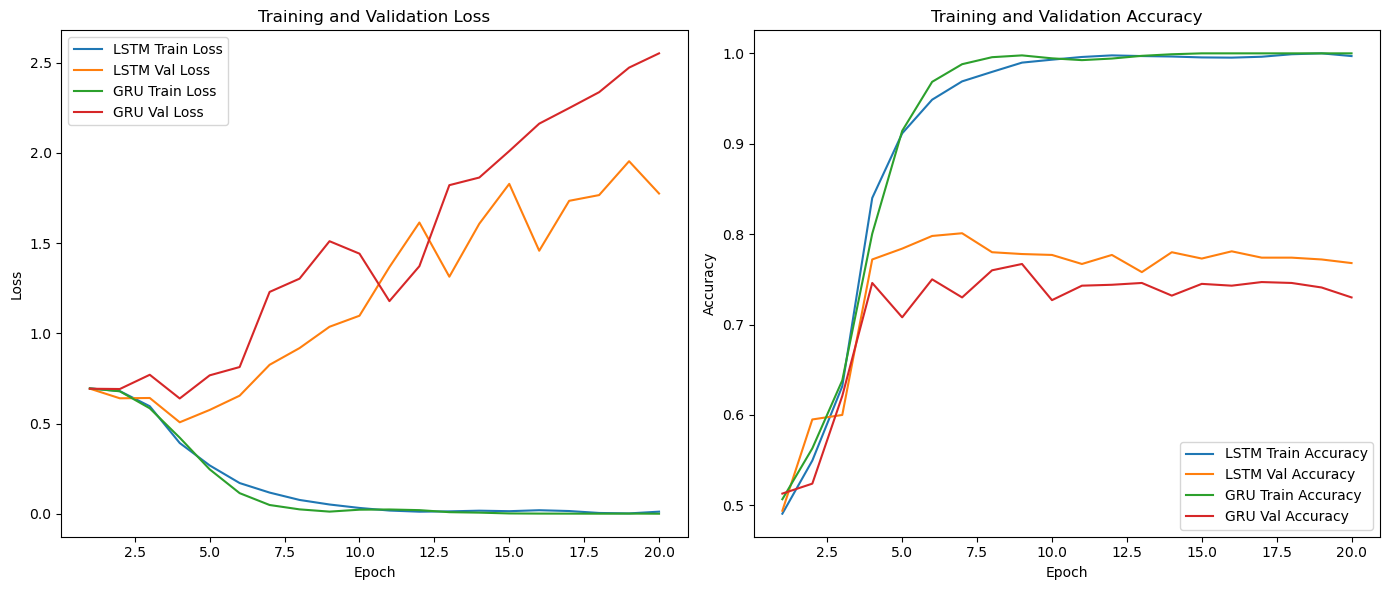

Performance Comparison Report:
LSTM training time: 701.32 seconds
GRU training time: 607.55 seconds

Final Performance:
LSTM - Train Accuracy: 99.70%, Val Accuracy: 76.80%
GRU  - Train Accuracy: 100.00%, Val Accuracy: 73.00%


In [ ]:
#plotting Loss and Accuracy
import matplotlib.pyplot as plt

# Dynamically generate the epoch range based on the history length
epochs_range = range(1, len(history_lstm.history['loss']) + 1)

plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(epochs_range, history_lstm.history['val_loss'], label='LSTM Val Loss')
plt.plot(epochs_range, history_gru.history['loss'], label='GRU Train Loss')
plt.plot(epochs_range, history_gru.history['val_loss'], label='GRU Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_lstm.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(epochs_range, history_lstm.history['val_accuracy'], label='LSTM Val Accuracy')
plt.plot(epochs_range, history_gru.history['accuracy'], label='GRU Train Accuracy')
plt.plot(epochs_range, history_gru.history['val_accuracy'], label='GRU Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Performance Comparison Report
print("Performance Comparison Report:")
print(f"LSTM training time: {lstm_time:.2f} seconds")
print(f"GRU training time: {gru_time:.2f} seconds\n")

print("Final Performance:")
print(f"LSTM - Train Accuracy: {history_lstm.history['accuracy'][-1]*100:.2f}%, Val Accuracy: {history_lstm.history['val_accuracy'][-1]*100:.2f}%")
print(f"GRU  - Train Accuracy: {history_gru.history['accuracy'][-1]*100:.2f}%, Val Accuracy: {history_gru.history['val_accuracy'][-1]*100:.2f}%")

Task 4. Text Generation with LSTM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import string
import random


In [ ]:
# Read Shakespeare text from a file
with open('shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Preprocess text: convert to lowercase, remove newlines and punctuation
text = text.lower().replace('\n', ' ')
text = text.translate(str.maketrans('', '', string.punctuation))
print("Corpus length:", len(text))

# Tokenize and Create Sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1
print("Total words in vocabulary:", total_words)

# Prepare sequences using a fixed sequence length (e.g., 50)
sequence_length = 50
input_sequences = []
words = text.split()
for i in range(sequence_length, len(words)):
    seq = words[i - sequence_length:i + 1]
    input_sequences.append(' '.join(seq))

print("Total input sequences:", len(input_sequences))

# Convert sequences to integer sequences
sequences = tokenizer.texts_to_sequences(input_sequences)
sequences = np.array(sequences)

indices = np.random.choice(len(sequences), size=5000, replace=False)
small_sequences = sequences[indices]
# Split into predictors (X) and label (y)
X = sequences[:, :-1]   # first 50 tokens as input
y = sequences[:, -1]    # 51st token as output


Corpus length: 798898
Total words in vocabulary: 10761
Total input sequences: 139752


In [ ]:
#Build the LSTM Model for Text Generation

model = Sequential([
    Embedding(input_dim=total_words, output_dim=100, input_shape=(sequence_length,)),
    LSTM(150, return_sequences=True),
    LSTM(100),
    Dense(total_words, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# Train the Model
epochs = 5
history = model.fit(X, y, epochs=epochs, batch_size=128)

C:\Users\Elshibek\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 50, 100)        │     1,076,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50, 150)        │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10761)          │     1,086,861 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,413,961 (9.21 MB)

 Trainable params: 2,413,961 (9.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 340s 307ms/step - accuracy: 0.0281 - loss: 7.1262
Epoch 2/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 331s 303ms/step - accuracy: 0.0417 - loss: 6.4913
Epoch 3/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 323s 296ms/step - accuracy: 0.0636 - loss: 6.2362
Epoch 4/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 327s 300ms/step - accuracy: 0.0782 - loss: 6.0401
Epoch 5/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 323s 295ms/step - accuracy: 0.0900 - loss: 5.8814


In [ ]:
#  Text Generation Function

def generate_text(seed_text, next_words, max_sequence_len):
    """
    Generate text by predicting the next word repeatedly.
    :param seed_text: the initial seed string.
    :param next_words: number of words to generate.
    :param max_sequence_len: the input sequence length used in training.
    :return: seed_text appended with generated words.
    """
    for _ in range(next_words):
        # Convert seed text to token sequence and pad
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
        # Predict next word (use argmax here; you might explore sampling for diversity)
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)[0]
        # Find the word corresponding to the predicted token index
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text


In [ ]:
# Generate and Compare Text with Different Seeds

seed_texts = [
    "to be or not to be",
    "the lady doth protest too much",
    "wherefore art thou",
    "all that glitters is not gold"
]

for seed in seed_texts:
    generated = generate_text(seed, next_words=50, max_sequence_len=sequence_length)
    print(f"\nSeed: {seed}\nGenerated Text:\n{generated}\n")


Seed: to be or not to be
Generated Text:
to be or not to be a world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world


Seed: the lady doth protest too much
Generated Text:
the lady doth protest too much and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the


Seed: wherefore art thou
Generated Text:
wherefore art thou art not i have not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not


Seed: all that glitters is not gold
Generated Text:
all that glitters is not gold and the world and the world and the world an